In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [1]:
### For Colab, install dependencies.

!pip install mxnet-cu110
!pip install gluonts
!pip install fredapi
!pip install stats-can
!pip install --upgrade scikit-learn

     |████████████████████████████████| 323.5 MB 369 bytes/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 2.1 MB 6.7 MB/s 
     |████████████████████████████████| 10.1 MB 30.1 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
     |████████████████████████████████| 4.3 MB 10.8 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
!pwd

/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting
/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting


In [110]:
import pandas as pd
pd.set_option('precision', 3)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [5]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "/content/drive/MyDrive/Colab Notebooks/foodprice-forecasting/output/nbeats_202110"

## Load Data Using APIs

In [112]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3
...,...,...,...,...,...,...,...,...,...
2021-04-01,156.2,146.1,145.1,163.2,155.4,141.9,173.5,140.5,151.1
2021-05-01,157.8,146.6,147.6,163.5,156.6,143.9,175.4,141.6,153.8
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4


# NBEATS Model and Experiments

## Data Splitting

For each such candidate forecast, we should record any uncertainty/confidence metrics it provides, and evaluation metrics for that same model configuration over the test set. i.e. When model configuration XYZ was used to forecast Meat prices over the test set (with that data not being used for training or validation!) - what were its evaluation metrics on the withheld data? We should report this consistently for ALL EXPERIMENTS. 

For all models, we will use the following "simulated" report dates. This is a form of cross validation over time. We train a model up to each cutoff date, and then produce and evaluate 18-month forecasts. We can then collect each model's validation metric, take the mean, and use this to do model selection for the final forecast (or ensemble of forecasts!).

In [7]:
report_sim_dates = ["2015-07-01", "2016-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]

In [8]:
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

## Fitting and Evaluating a Single NBEATS Model: Example Using All Food Prices

In [49]:
N = foodprice_df.shape[1]
T = foodprice_df.shape[0]
prediction_length = 18
freq = "MS"
dataset = foodprice_df.T.values
start = pd.Timestamp("2016-07-01", freq=freq)

In [50]:
from gluonts.dataset.common import ListDataset

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset[:, :-prediction_length]],
    freq=freq
)
# valid dataset: use the whole dataset, add "target" and "start" fields
valid_ds = ListDataset(
    [{'target': x, 'start': start} for x in dataset],
    freq=freq
)



In [51]:
next(iter(valid_ds))

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2016-07-01 00:00:00', freq='MS'),
 'target': array([ 69.3,  70.3,  70.6,  71.3,  71.2,  71.1,  71.7,  71.9,  71.7,
         71.1,  71.6,  72.2,  72.6,  72.3,  72.8,  72.6,  73.2,  72.6,
         73.7,  73.6,  73.3,  73.1,  73.6,  73.7,  74.4,  74.3,  74.6,
         74.9,  74.9,  75.9,  75.9,  76.3,  76.1,  76.8,  76.8,  76.7,
         76.9,  76.8,  77.3,  77.5,  77.2,  77.4,  78.1,  78.5,  78.2,
         79.3,  79.1,  79.8,  80.3,  80.5,  80.7,  81.2,  80.6,  81. ,
         80.8,  80.4,  81. ,  81.5,  81.8,  82.3,  82.6,  81.7,  82.2,
         82. ,  81. ,  81.8,  81.1,  81.2,  81.1,  81.4,  81.5,  81.6,
         81.2,  81. ,  81.5,  81.6,  82.1,  82.6,  82.9,  82.9,  83.1,
         83. ,  83.2,  83.6,  83.3,  83.3,  82.9,  82.9,  82.6,  83.2,
         83.9,  83.8,  83.2,  84. ,  84.1,  84.4,  84.4,  84.4,  84.4,
         85.2,  84.5,  84.7,  85. ,  84.8,  84.9,  85.7,  85.5,  86.2,
         86.8,  88. ,  88. ,  

In [52]:
dataset.shape

(9, 428)

In [53]:
dataset_df = foodprice_df.T
dataset_df

REF_DATE,1986-01-01,1986-02-01,1986-03-01,1986-04-01,1986-05-01,1986-06-01,1986-07-01,1986-08-01,1986-09-01,1986-10-01,1986-11-01,1986-12-01,1987-01-01,1987-02-01,1987-03-01,1987-04-01,1987-05-01,1987-06-01,1987-07-01,1987-08-01,1987-09-01,1987-10-01,1987-11-01,1987-12-01,1988-01-01,1988-02-01,1988-03-01,1988-04-01,1988-05-01,1988-06-01,1988-07-01,1988-08-01,1988-09-01,1988-10-01,1988-11-01,1988-12-01,1989-01-01,1989-02-01,1989-03-01,1989-04-01,...,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01
Bakery and cereal products (excluding baby food),69.3,70.3,70.6,71.3,71.2,71.1,71.7,71.9,71.7,71.1,71.6,72.2,72.6,72.3,72.8,72.6,73.2,72.6,73.7,73.6,73.3,73.1,73.6,73.7,74.4,74.3,74.6,74.9,74.9,75.9,75.9,76.3,76.1,76.8,76.8,76.7,76.9,76.8,77.3,77.5,...,151.6,151.2,151.3,151.8,149.6,152.3,152.2,153.7,153.8,155.1,154.1,152.4,154.8,154.4,156.0,156.8,154.2,156.0,156.4,156.9,156.9,157.9,159.6,158.7,160.2,158.9,156.9,157.8,155.1,156.6,155.2,156.4,154.2,157.1,156.8,156.2,157.8,157.7,157.9,158.5
Dairy products and eggs,70.9,70.8,71.1,71.0,71.4,71.1,71.3,71.5,71.8,71.8,72.1,72.5,72.5,72.8,72.4,72.2,72.4,72.4,72.4,72.9,73.5,73.1,73.2,73.1,73.4,73.8,74.1,74.4,75.4,75.5,75.9,76.3,76.5,76.4,76.3,76.4,77.1,77.2,76.9,77.0,...,133.6,133.3,133.5,134.3,134.6,133.6,134.9,135.7,135.9,137.6,137.1,136.3,137.8,136.2,137.7,137.9,138.0,135.5,137.1,138.4,138.8,140.5,140.3,142.8,142.8,142.1,141.2,142.3,140.8,140.5,141.6,141.5,141.6,143.1,144.9,146.1,146.6,145.3,146.4,148.3
"Fish, seafood and other marine products",60.6,61.3,61.3,61.4,61.9,62.0,62.2,62.7,63.1,63.6,65.3,65.9,67.1,67.5,67.6,67.6,67.8,67.9,68.4,69.0,69.3,70.3,70.3,70.4,71.4,72.0,72.6,72.9,73.7,73.8,74.3,75.2,76.0,77.1,77.2,77.0,77.2,77.2,77.0,77.6,...,137.2,138.1,138.2,138.1,136.4,135.7,137.8,139.5,140.9,142.1,142.5,140.7,142.7,140.4,142.3,142.1,141.9,143.3,144.6,144.0,144.2,144.3,146.0,144.4,149.0,145.7,144.5,146.8,143.5,143.6,145.0,144.7,143.4,143.9,144.9,145.1,147.6,146.2,146.6,146.8
Food purchased from restaurants,59.1,59.1,59.3,59.7,59.9,60.0,60.6,60.9,60.9,61.3,61.6,61.7,62.1,62.1,62.3,62.3,62.7,62.3,62.7,62.9,63.1,63.4,63.6,63.7,64.1,64.4,64.5,64.8,65.3,65.4,65.9,66.2,66.4,66.7,67.0,67.2,67.6,67.8,68.1,68.3,...,152.1,152.4,152.9,153.2,153.2,153.8,154.1,153.9,154.9,154.5,155.3,155.7,155.9,156.4,156.9,157.4,157.4,158.0,158.1,157.9,158.2,158.3,158.1,159.2,159.3,159.5,160.2,160.7,160.9,161.5,161.6,161.6,162.6,162.9,162.6,163.2,163.5,163.9,165.2,165.9
Food,67.3,66.9,67.0,67.7,68.2,68.4,69.2,69.5,69.9,70.2,70.6,70.5,71.2,71.2,71.2,71.2,71.8,72.6,72.8,72.1,71.7,71.8,72.1,72.1,72.8,72.6,72.5,72.8,73.3,73.9,74.6,74.8,74.6,74.6,74.3,74.1,74.9,75.6,75.6,75.9,...,144.6,145.6,146.1,145.9,144.9,144.6,146.1,147.5,148.7,149.3,149.4,149.0,149.7,150.7,151.6,151.1,150.2,149.9,151.1,151.9,153.5,152.9,152.8,154.0,154.3,154.8,155.0,153.8,152.6,153.3,153.9,153.6,155.0,155.6,155.5,155.4,156.6,156.8,157.6,158.0
"Fruit, fruit preparations and nuts",76.0,77.6,79.2,82.2,83.5,83.1,84.8,86.7,83.8,82.9,78.9,76.1,77.4,79.4,79.6,79.3,82.6,88.2,87.8,85.9,83.0,81.6,80.9,78.6,78.6,81.5,81.6,82.6,85.4,90.3,91.0,92.2,91.4,88.1,84.6,80.3,79.4,78.7,80.9,82.1,...,133.1,136.3,138.7,135.8,131.6,128.7,131.8,135.5,136.1,136.3,137.8,136.3,136.1,139.7,136.3,136.2,133.8,135.0,137.9,144.9,142.5,137.1,133.4,138.8,138.3,139.0,141.7,140.9,138.1,140.3,139.6,140.0,140.9,143.4,142.4,141.9,143.9,144.5,141.7,142.5
Meat,65.1,64.2,64.2,63.6,64.0,64.9,66.5,67.8,71.3,71.5,72.1,72.9,72.8,71.0,70.5,71.2,72.0,73.0,73.4,74.6,73.8,74.3,73.8,72.3,72.9,72.0,72.3,72.2,72.0,72.9,73.6,73.8,73.8,73.6,72.9,72.9,73.5,73.6,74.0,74.4,...,156.3,157.6,158.7,159.7,159.4,157.6,158.8,158

In [54]:
# valid dataset: use the whole dataset, add "target" and "start" fields
report_sim_date = "2016-07-01"
report_train_dates = sim_train_dates[report_sim_date]
report_valid_dates = sim_valid_dates[report_sim_date]

valid_ds_report = ListDataset(
    [{'target': x, 'start': start} for x in dataset_df[report_valid_dates].values],
    freq=freq
)


In [55]:
next(iter(valid_ds_report))

{'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2016-07-01 00:00:00', freq='MS'),
 'target': array([155.3, 151.5, 151.9, 149.6, 149.7, 150.4, 150.5, 150.7, 151.6,
        151.2, 151.7, 152.3, 153. , 150.8, 152.9, 151.6, 152.3, 151. ],
       dtype=float32)}

In [72]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', food_category:'y'}, axis=1)
    return df

In [32]:
import mxnet as mx
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx import Trainer



TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=10, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


In [33]:
predictor = estimator.train(train_ds)

100%|██████████| 50/50 [00:04<00:00, 12.19it/s, epoch=10/10, avg_epoch_loss=0.153]


TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


100%|██████████| 50/50 [00:04<00:00, 12.10it/s, epoch=50/50, avg_epoch_loss=0.086]


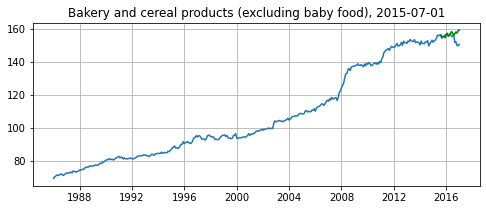

r2_score    -1.919
mae          2.674
mape         0.018
mse         16.872
rmse         4.108
dtype: float64


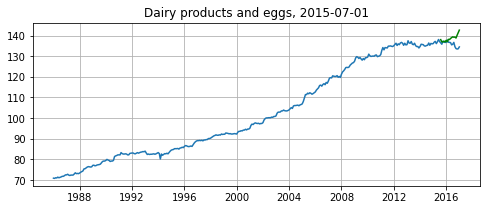

r2_score    -7.758
mae          2.910
mape         0.022
mse         14.742
rmse         3.840
dtype: float64


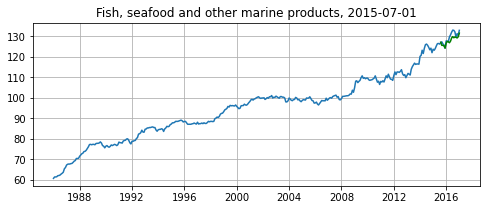

r2_score    0.489
mae         1.486
mape        0.011
mse         3.676
rmse        1.917
dtype: float64


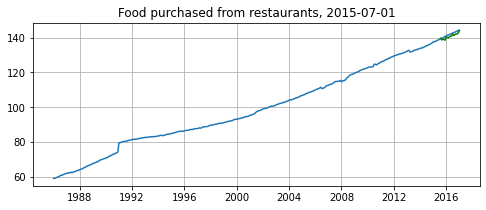

r2_score    0.273
mae         1.187
mape        0.008
mse         1.651
rmse        1.285
dtype: float64


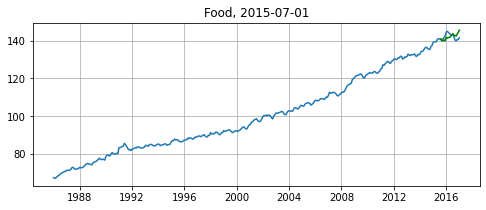

r2_score   -1.100
mae         1.941
mape        0.014
mse         5.347
rmse        2.312
dtype: float64


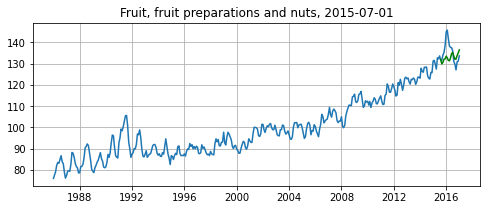

r2_score    -0.342
mae          4.690
mape         0.034
mse         34.245
rmse         5.852
dtype: float64


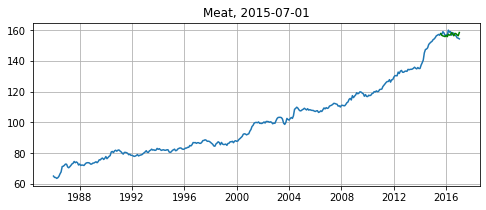

r2_score   -0.493
mae         1.572
mape        0.010
mse         3.388
rmse        1.841
dtype: float64


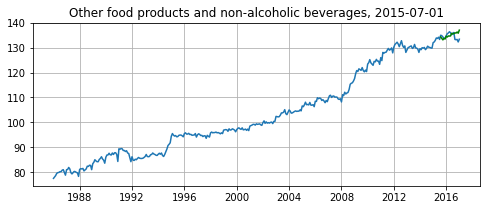

r2_score   -1.337
mae         1.437
mape        0.011
mse         3.349
rmse        1.830
dtype: float64


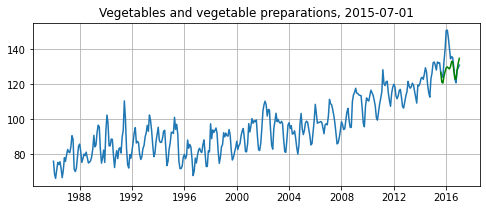

r2_score    -0.169
mae          6.662
mape         0.047
mse         92.035
rmse         9.593
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


100%|██████████| 50/50 [00:04<00:00, 12.15it/s, epoch=50/50, avg_epoch_loss=0.0892]


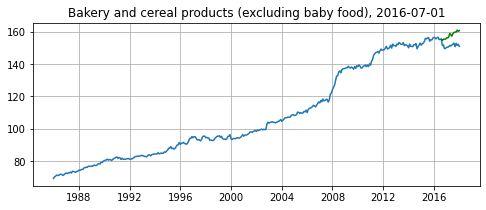

r2_score   -24.850
mae          6.236
mape         0.041
mse         43.980
rmse         6.632
dtype: float64


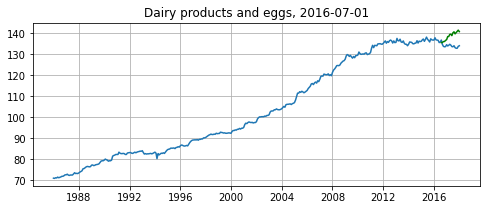

r2_score   -36.847
mae          4.774
mape         0.036
mse         27.722
rmse         5.265
dtype: float64


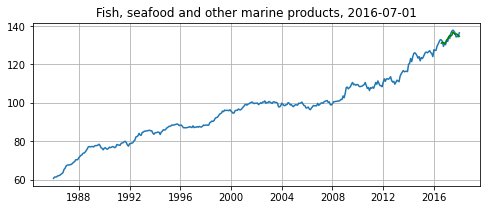

r2_score    0.729
mae         1.129
mape        0.008
mse         1.646
rmse        1.283
dtype: float64


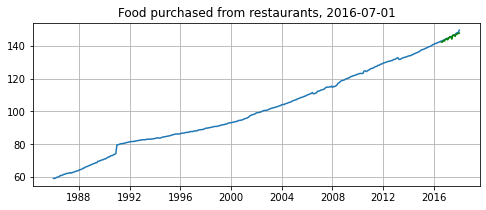

r2_score    0.805
mae         0.639
mape        0.004
mse         0.680
rmse        0.825
dtype: float64


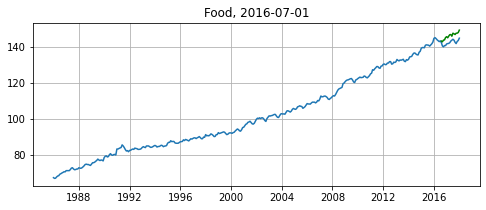

r2_score    -7.512
mae          3.694
mape         0.026
mse         14.814
rmse         3.849
dtype: float64


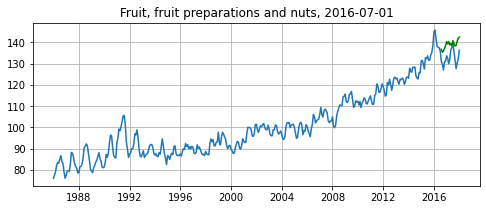

r2_score    -3.581
mae          6.494
mape         0.049
mse         50.205
rmse         7.086
dtype: float64


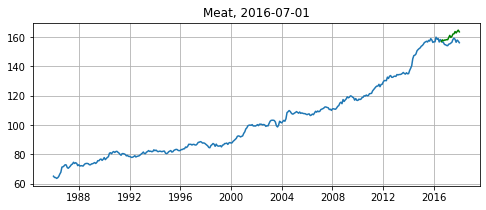

r2_score    -8.990
mae          4.169
mape         0.027
mse         21.080
rmse         4.591
dtype: float64


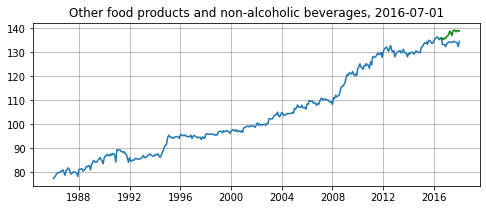

r2_score   -20.465
mae          3.650
mape         0.027
mse         15.204
rmse         3.899
dtype: float64


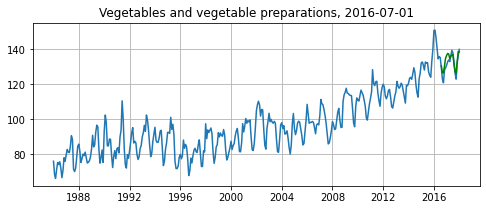

r2_score    0.668
mae         2.661
mape        0.021
mse         9.992
rmse        3.161
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


100%|██████████| 50/50 [00:04<00:00, 12.08it/s, epoch=50/50, avg_epoch_loss=0.0933]


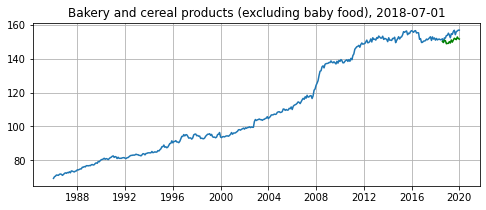

r2_score    -3.034
mae          3.674
mape         0.024
mse         16.111
rmse         4.014
dtype: float64


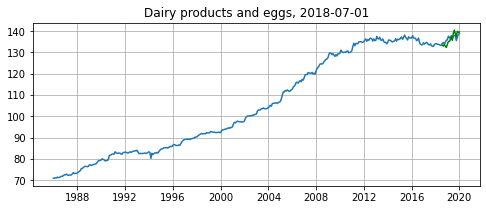

r2_score   -0.405
mae         1.500
mape        0.011
mse         3.100
rmse        1.761
dtype: float64


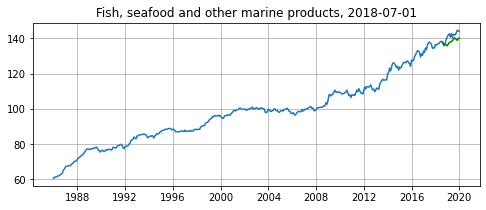

r2_score    -0.888
mae          3.073
mape         0.022
mse         12.386
rmse         3.519
dtype: float64


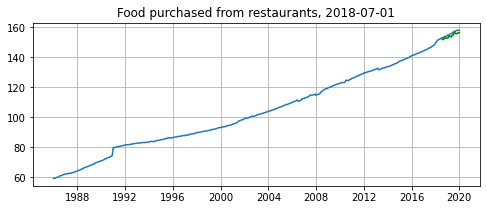

r2_score    0.189
mae         1.475
mape        0.009
mse         2.424
rmse        1.557
dtype: float64


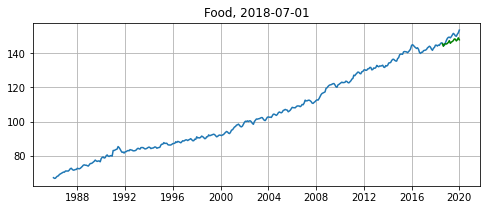

r2_score   -0.425
mae         2.583
mape        0.017
mse         8.402
rmse        2.899
dtype: float64


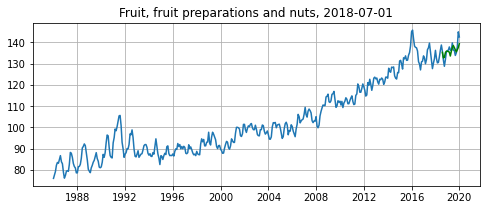

r2_score    0.454
mae         2.047
mape        0.015
mse         7.210
rmse        2.685
dtype: float64


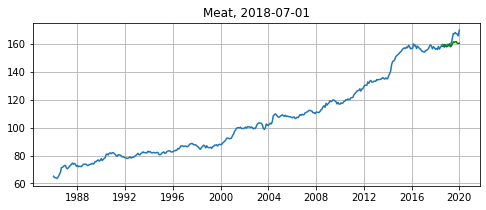

r2_score    -0.135
mae          3.461
mape         0.021
mse         19.308
rmse         4.394
dtype: float64


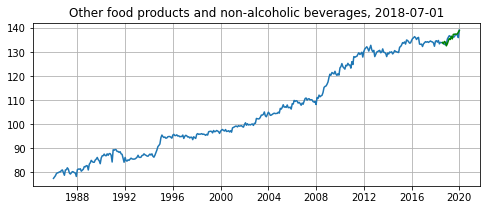

r2_score    0.573
mae         0.855
mape        0.006
mse         1.124
rmse        1.060
dtype: float64


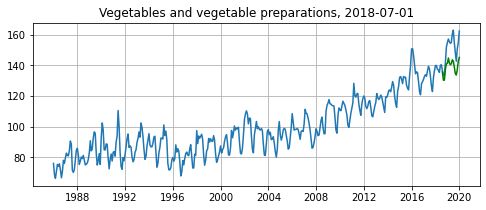

r2_score     -0.962
mae          11.573
mape          0.075
mse         161.673
rmse         12.715
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


100%|██████████| 50/50 [00:04<00:00, 11.98it/s, epoch=50/50, avg_epoch_loss=0.128]


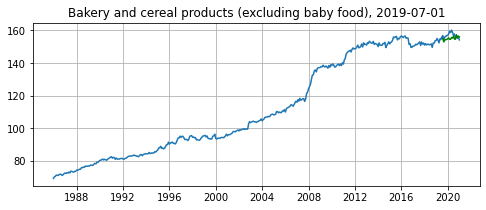

r2_score   -1.392
mae         2.138
mape        0.014
mse         6.556
rmse        2.561
dtype: float64


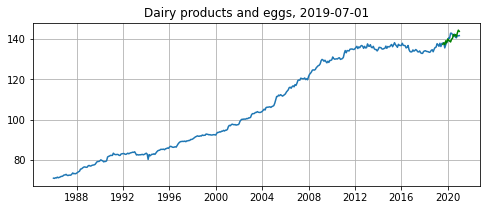

r2_score    0.196
mae         1.525
mape        0.011
mse         3.383
rmse        1.839
dtype: float64


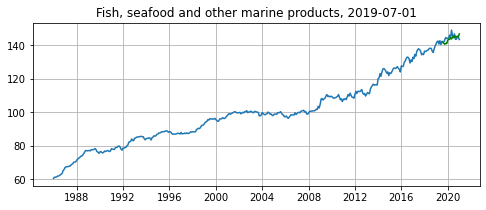

r2_score   -0.926
mae         1.776
mape        0.012
mse         5.019
rmse        2.240
dtype: float64


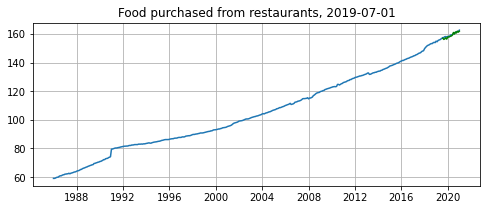

r2_score    0.749
mae         0.699
mape        0.004
mse         0.657
rmse        0.811
dtype: float64


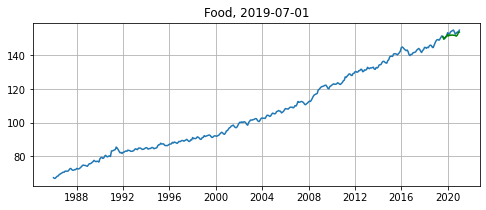

r2_score   -0.021
mae         1.279
mape        0.008
mse         2.391
rmse        1.546
dtype: float64


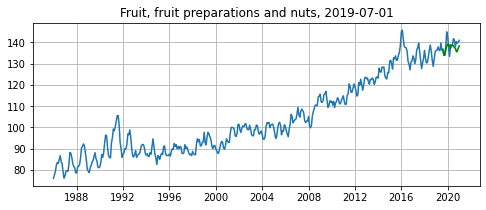

r2_score   -0.114
mae         2.482
mape        0.018
mse         9.423
rmse        3.070
dtype: float64


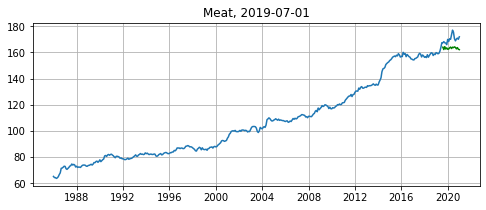

r2_score    -6.032
mae          6.917
mape         0.040
mse         55.977
rmse         7.482
dtype: float64


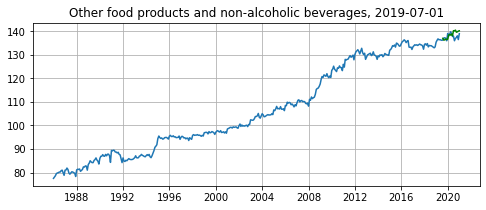

r2_score   -2.092
mae         1.501
mape        0.011
mse         3.802
rmse        1.950
dtype: float64


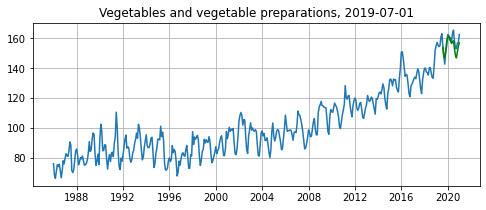

r2_score     0.490
mae          3.337
mape         0.021
mse         16.046
rmse         4.006
dtype: float64
TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, batch_size=None, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("gpu", 0), epochs=50, hybridize=True, init="xavier", learning_rate=0.001, learning_rate_decay_factor=0.5, minimum_learning_rate=5e-05, num_batches_per_epoch=50, patience=10, weight_decay=1e-08)


100%|██████████| 50/50 [00:04<00:00, 11.96it/s, epoch=50/50, avg_epoch_loss=0.101]


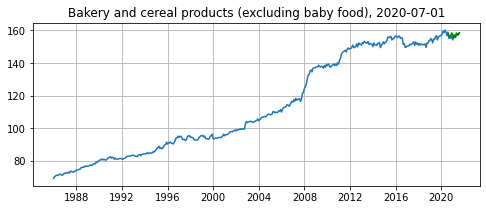

r2_score   -0.400
mae         1.122
mape        0.007
mse         2.119
rmse        1.456
dtype: float64


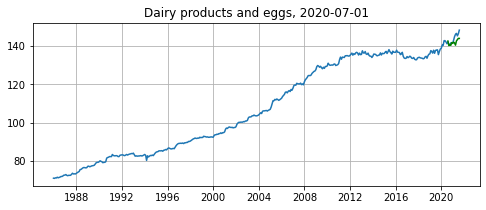

r2_score   -0.108
mae         1.955
mape        0.013
mse         6.919
rmse        2.630
dtype: float64


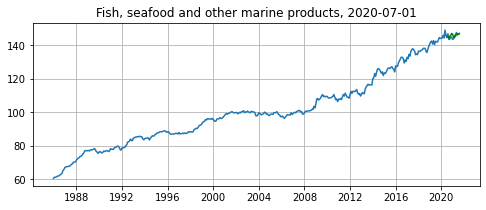

r2_score    0.054
mae         1.034
mape        0.007
mse         1.790
rmse        1.338
dtype: float64


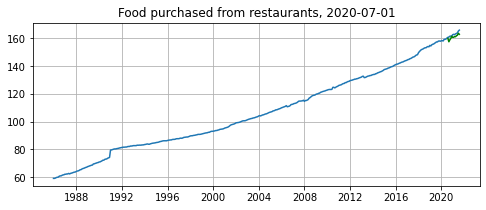

r2_score   -0.759
mae         1.833
mape        0.011
mse         4.047
rmse        2.012
dtype: float64


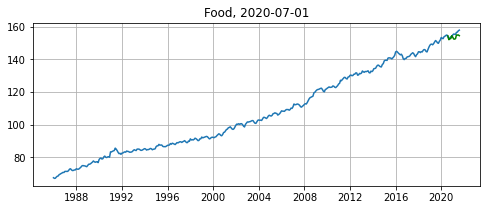

r2_score   -0.551
mae         1.786
mape        0.011
mse         4.179
rmse        2.044
dtype: float64


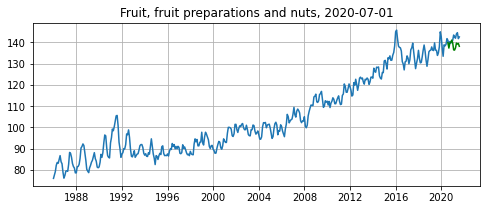

r2_score    -3.579
mae          3.006
mape         0.021
mse         14.066
rmse         3.750
dtype: float64


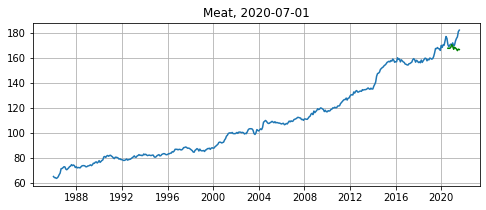

r2_score    -2.028
mae          5.502
mape         0.031
mse         53.959
rmse         7.346
dtype: float64


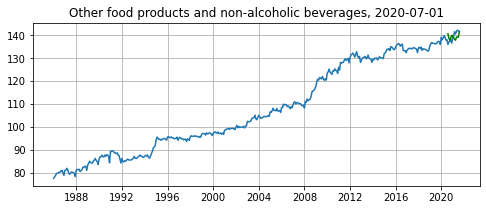

r2_score   -0.281
mae         2.065
mape        0.015
mse         6.050
rmse        2.460
dtype: float64


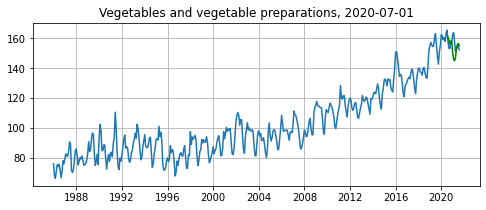

r2_score    -2.965
mae          5.175
mape         0.033
mse         54.871
rmse         7.407
dtype: float64


In [114]:
from gluonts.evaluation import make_evaluation_predictions

all_valid_metrics = {}

for report_sim_date in report_sim_dates:

    report_train_dates = sim_train_dates[report_sim_date]
    report_valid_dates = sim_valid_dates[report_sim_date]
    
    # train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
    train_ds = ListDataset(
        [{'target': x, 'start': start} for x in dataset_df[list(report_train_dates)].values],
        freq=freq
    )

    valid_ds_report = ListDataset(
        [{'target': x, 'start': start} for x in dataset_df[list(report_train_dates) + list(report_valid_dates)].values],
        freq='MS'
    )

    estimator = NBEATSEnsembleEstimator(
        prediction_length=prediction_length,
        #context_length=7*prediction_length,
        meta_bagging_size = 3,  # 3, ## Change back to 10 after testing??
        meta_context_length = [prediction_length * mlp for mlp in [3,5,7] ], ## Change back to (2,7) // 3,5,7
        meta_loss_function = ['sMAPE'], ## Change back to all three MAPE, MASE ...
        num_stacks = 30,
        widths= [512],
        freq="MS",
        trainer=Trainer(
                    # learning_rate=6e-4,
                    #clip_gradient=1.0,
                    epochs=50,
                    # num_batches_per_epoch=1000,
                    # batch_size=16,
                    ctx=mx.context.gpu()
                )

    )

    predictor = estimator.train(train_ds)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=valid_ds_report,  # test dataset
        predictor=predictor,  # predictor
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    all_fc_dates = list(report_train_dates) + list(report_valid_dates)

    all_food_metrics = {}

    for target_index in range(len(forecasts)):

        # Get food price category
        foodprice_category = foodprice_df.columns[target_index]

        # plot actual
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(all_fc_dates, foodprice_df[foodprice_category][all_fc_dates])

        # plot forecast
        forecast_entry = forecasts[target_index]
        ax.plot(report_valid_dates, forecast_entry.mean[:len(report_valid_dates)], color='green')

        plt.title(f"{foodprice_category}, {report_sim_date}")
        plt.grid()
        plt.show()

        fc_metrics = pd.Series({metric_name: metric_fn(y_true=foodprice_df[foodprice_category][report_valid_dates], y_pred=forecast_entry.mean[:len(report_valid_dates)]) for metric_name, metric_fn in metrics.items()})
        print(fc_metrics)

        all_food_metrics[foodprice_category] = fc_metrics

        # print(valid_df)
        # print(valid_forecast)

    all_valid_metrics[report_sim_date] = all_food_metrics

In [116]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-6.319,3.169,0.021,17.128,3.754
Dairy products and eggs,-8.984,2.533,0.019,11.173,3.067
"Fish, seafood and other marine products",-0.109,1.700,0.012,4.903,2.060
Food purchased from restaurants,0.251,1.167,0.008,1.892,1.298
Food,-1.922,2.256,0.015,7.027,2.530
"Fruit, fruit preparations and nuts",-1.432,3.744,0.027,23.030,4.489
Meat,-3.535,4.324,0.026,30.742,5.131
Other food products and non-alcoholic beverages,-4.720,1.902,0.014,5.906,2.240
Vegetables and vegetable preparations,-0.588,5.882,0.039,66.923,7.377


## Fit Models Using All Data To Produce Final Forecast

## Predicted Change in CPI By Category

For the report, we usually express forecasts as the predicted percentage change, overall for the next year. We can do this by comparing the mean forecasted CPI for 2022 to the mean (known and predicted) values for 2021.